# Training a next level deep neural network on fashion mnist dataset
<p>
    In this notebook, I use our <b><i>next level deep learning from scratch</b></i> code to train a deep neural network on fashion mnist dataset. This dataset is a bit different from the original fashion mnist. It's been undergone unspecified dimensionality reduction and was supplied to me as part of my studies in Master of Data science in the University of Sydney. At the time of writing this code we weren't told anything about the data that we were given.
</p>
<p>
    The training data is made of 60000 samples each sample having 128 features. There are 10 classes in this dataset and our training set has a balanced samples where each labels have 6000 training examples. Test data were provided and test labels were held out.
</p>
<p>
    I will not be exploring the dataset any further as this is outside the scope of this notebook.
</p>

<p>
    Now let's start training and fine tuning our <b><i>next level deep neural network model</b></i> to achieve the best accuracy we can get. Then we evaluate our final model against test labels loaded from keras datasets.
</p>

<h2>1- Importing code, loading data and preprocessing</h2>
<p>
    This notebook can run on GPU if you have CuPy and compatible NVidia GPU installed.<br>
After importing all required code, the data is loaded into CuPy arrays if running on GPU or Numpy arrays if running on CPU.
</p>
</p>
<p>We perform few simple preprocessing steps on the dataset:
    <li>
        split the dataset into training and validation sets.
    </li>
    <li>
        feature standarization: by subtracting the mean from our data and dividing by standard deviation, we make our features have zero mean (centred around zero) and unit-variance using the following equation<br>
    </li>
</p>
\begin{equation*}
    x^{'}=\frac{x-\hat{x}}{\sigma}
\end{equation*}
    where:<br>
    $x^{'}$: is dataset with zero mean and unit variance<br>
    $\hat{x}$: is the mean<br>
    $\sigma$: is standard deviation<br><br>
<li>
    labels are converted to one hot encoding labels where each data point has a a vector of size <i>n</i>-classes. The vector has value of 1 at the <i>ith</i> element and <i>zeros</i> elsewhere to indicate that this data point belongs to the <i>ith</i> class
</li>


In [1]:
# importing libraries and code
try:
    import cupy as np
except ImportError:
    import numpy as np
from DeepLearning import NN, Layers, Utils, Losses, Optimizers, Regularizers, Metrics
import h5py
import numpy
import matplotlib.pyplot as plt
from numpy.random import uniform

# loading dataset with labels
path = './input/'

with h5py.File(path+'train_128.h5','r') as H:
    data = np.asarray(numpy.copy(H['data']))
with h5py.File(path+'train_label.h5','r') as H:
    label = numpy.copy(H['label'])

# convert labels to one hot encoding
label = np.asarray(Utils.to_categorical(label))

n = 50000

# split dataset into training and validation and standarize features
def split_dataset(data, label, n):
    indices = np.array(range(data.shape[0]))
    indices = np.random.choice(indices, size=indices.shape)
    x_train = data[indices[:n]]
    y_train = label[indices[:n]]
    x_val = data[indices[n:]]
    y_val = label[indices[n:]]

    std_x = np.std(x_train)
    mean_x = np.mean(x_train)

    x_train = (x_train - mean_x) / std_x
    x_val = (x_val - mean_x) / std_x
    return x_train, y_train, x_val, y_val

x_train, y_train, x_val, y_val = split_dataset(data, label, n)

Training network on GPU...



## 2- Adding code to plot contour lines
<p>
    To help us visulize results more effeciently we write a simple code that plots our random or grid search results into contour lines
</p>

In [2]:
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from numpy.random import uniform, seed

def plot_contour(x, y, z, xlabel, ylabel, title, npts=100):
    try:
        x = np.asnumpy(x)
        y = np.asnumpy(y)
        z = np.asnumpy(z)
    except:
        pass
    xs = int(min(x) * 100) / 100.0
    xe = (int(max(x)*100)) / 100
    ys = int(min(y) * 100) / 100.0
    ye = (int(max(y)*100)) / 100
    # define grid.
    xi = numpy.linspace(xs,xe,100)
    yi = numpy.linspace(ys, ye,100)
    # grid the data.
    zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='linear')
    # contour the gridded data, plotting dots at the randomly spaced data points.
    CS = plt.contour(xi,yi,zi,15,linewidths=0.5,colors='k')
    CS = plt.contourf(xi,yi,zi,15,cmap=plt.cm.jet)
    plt.colorbar() # draw colorbar
    # plot data points.
    plt.scatter(x, y,marker='o',c='g',s=5)
    plt.xlim(xs,xe)
    plt.ylim(ys, ye)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

## 3 - Experimenting with activations
<p>
    Here we start experiementing with activations.<br>
    The neural network used has the following layers:<br>
<table>
    <tr>
        <th>layer</th>
        <th>number<br>of neurons</th>
    </tr>
    <tr>
        <td>input<br>layer</td>
        <td>128</td>
    </tr>
    <tr>
        <td>hidden<br>layer 1</td>
        <td>96</td>
    </tr>
    <tr>
        <td>hidden<br>layer 2</td>
        <td>64</td>
    </tr>
    <tr>
        <td>output<br>layer</td>
        <td>10</td>
    </tr>
</table>
    The model parameter used are listed in the table below<br>
<table>
    <tr>
        <th>technique</th>
        <th>hyper<br>parameter</th>
        <th>value</th>
    </tr>
    <tr>
        <td>loss</td>
        <td>softmax<br>cross entropy</td>
        <td>-</td>
    </tr>
    <tr>
        <td>optimizer</td>
        <td>gradient<br>descent</td>
        <td> - </td>
    </tr>
    <tr>
        <td>L2<br>regularization</td>
        <td>$\lambda$</td>
        <td>0.001</td>
    </tr>
    <tr>
        <td>momentum</td>
        <td>$\gamma$</td>
        <td>0.9</td>
    </tr>
    <tr>
        <td>learning<br>rate</td>
        <td>$\alpha$</td>
        <td>0.01</td>
    </tr>
    <tr>
        <td>number of<br>iterations</td>
        <td>epochs</td>
        <td>100</td>
    </tr>
    <tr>
        <td>output layer<br>activation</td>
        <td>softmax</td>
        <td> - </td>
    </tr>
</table>
</p>
<p>
    The table below summerize results for this experiment
</p>
<table>
    <tr>
        <th>activation</th>
        <th>validation<br>accuracy</th>
        <th>validation<br>loss</th>
    </tr>
    <tr>
        <td>sigmoid</td>
        <td>11.52%</td>
        <td>6.69</td>
    </tr>
    <tr>
        <td>tanh</td>
        <td>7.16%</td>
        <td> 3.13 </td>
    </tr>
    <tr>
        <td>relu</td>
        <td> 10.05%</td>
        <td> nan</td>
    </tr>
    <tr>
        <td>lrelu</td>
        <td> 10.05%</td>
        <td> nan</td>
    </tr>
    <tr>
        <td>elu</td>
        <td>9.77%</td>
        <td>nan</td>
    </tr>
</table>

In [7]:
clf = NN(Losses.softmax_cross_entropy, Optimizers.SGD, regularizer=Regularizers.l2, reg_lambda=0.001)
clf.add(Layers.Dense(128, input_dim=n))
clf.add(Layers.Dense(96, activation='sigmoid'))
clf.add(Layers.Dense(64, activation='sigmoid'))
clf.add(Layers.Dense(10, activation='softmax'))
epochs = 100
result = clf.fit(x_train,
                 y_train,
                 learning_rate=0.01,
                 batch_size=n,
                 epochs=epochs,
                 print_freq=5,
                 gamma=0.9,
                 validation=(x_val, y_val))

 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 6/100 training loss = 11.4666, training accuracy = 6.973999%   validation loss = 11.5176, validation accuracy = 6.69%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 11/100 training loss = 11.4046, training accuracy = 7.138%   validation loss = 11.5176, validation accuracy = 6.69%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 16/100 training loss = 11.4185, training accuracy = 7.136000%   validation loss = 11.5176, validation accuracy = 6.69%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 21/100 training loss = 11.4631, training accuracy = 7.08%   validation loss = 11.5176, validation accuracy = 6.69%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 26/100 training loss = 11.4838, training accuracy = 6.944%   validation loss = 11.5176, validation accuracy = 6.69%   
 [████

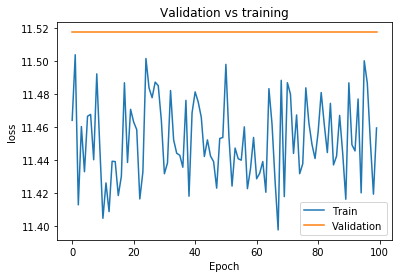

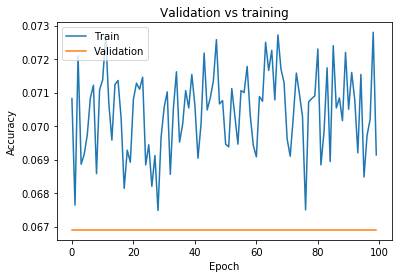

In [8]:
def plot_results(result):
    loss, acc, val_loss, val_acc = result['Loss'], result['Accuracy'], result['Val Loss'], result['Val Accuracy']
    epoch = [i for i in range(len(loss))]
    plt.plot(epoch, loss)
    plt.plot(epoch, val_loss)
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.title('Validation vs training')
    plt.legend(labels=['Train','Validation'])
    plt.show()
    plt.plot(epoch, acc)
    plt.plot(epoch, val_acc)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation vs training')
    plt.legend(labels=['Train','Validation'])
    plt.show()

plot_results(result)

In [0]:
clf = NN(Losses.softmax_cross_entropy, Optimizers.SGD, regularizer=Regularizers.l2, reg_lambda=0.001)
clf.add(Layers.Dense(128, input_dim=n))
clf.add(Layers.Dense(96, activation='tanh'))
clf.add(Layers.Dense(64, activation='tanh'))
clf.add(Layers.Dense(10, activation='softmax'))
epochs = 100
result = clf.fit(x_train,
                 y_train,
                 learning_rate=0.01,
                 batch_size=n,
                 epochs=epochs,
                 print_freq=5,
                 gamma=0.9,
                 validation=(x_val, y_val))


Epoch 0/100
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 5/100 training loss = 13.8060, training accuracy = 5.47%   validation loss = 13.7194, validation accuracy = 5.72%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 10/100 training loss = 13.7734, training accuracy = 5.608%   validation loss = 13.6849, validation accuracy = 5.79%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 15/100 training loss = 13.7623, training accuracy = 5.74%   validation loss = 13.6518, validation accuracy = 5.850000%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 20/100 training loss = 13.6999, training accuracy = 5.814%   validation loss = 13.6188, validation accuracy = 5.93%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 25/100 training loss = 13.6647, training accuracy = 5.896%   validation loss = 13.5861, validation accuracy = 6.03%

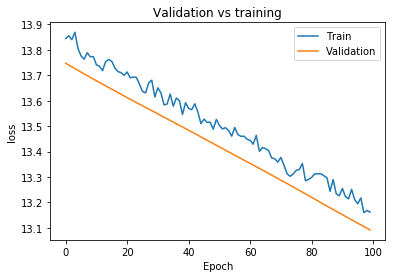

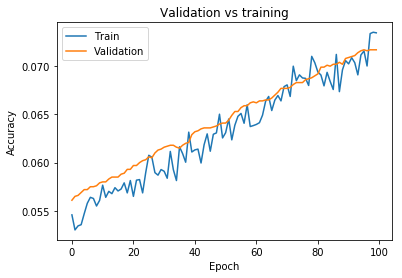

In [0]:
plot_results(result)

In [0]:
clf = NN(Losses.softmax_cross_entropy, Optimizers.SGD, regularizer=Regularizers.l2, reg_lambda=0.001)
clf.add(Layers.Dense(128, input_dim=n))
clf.add(Layers.Dense(96, activation='relu'))
clf.add(Layers.Dense(64, activation='relu'))
clf.add(Layers.Dense(10, activation='softmax'))
epochs = 100
result = clf.fit(x_train,
                 y_train,
                 learning_rate=0.01,
                 batch_size=n,
                 epochs=epochs,
                 print_freq=5,
                 gamma=0.9,
                 validation=(x_val, y_val))


Epoch 0/100
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 5/100 training loss = nan, training accuracy = 10.31200%   validation loss = nan, validation accuracy = 10.05%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 10/100 training loss = nan, training accuracy = 10.33599%   validation loss = nan, validation accuracy = 10.05%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 15/100 training loss = nan, training accuracy = 9.968%   validation loss = nan, validation accuracy = 10.05%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 20/100 training loss = nan, training accuracy = 10.064%   validation loss = nan, validation accuracy = 10.05%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 25/100 training loss = nan, training accuracy = 9.991999%   validation loss = nan, validation accuracy = 10.05%   
 [█████████████████████

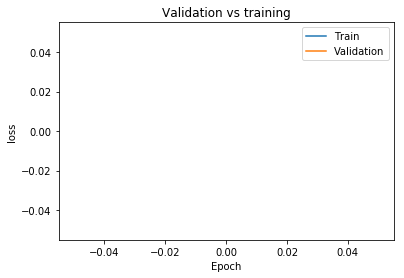

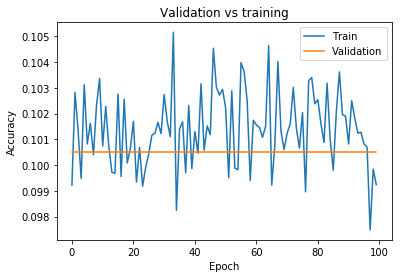

In [0]:
plot_results(result)

In [0]:
clf = NN(Losses.softmax_cross_entropy, Optimizers.SGD, regularizer=Regularizers.l2, reg_lambda=0.001)
clf.add(Layers.Dense(128, input_dim=n))
clf.add(Layers.Dense(96, activation='lrelu'))
clf.add(Layers.Dense(64, activation='lrelu'))
clf.add(Layers.Dense(10, activation='softmax'))
epochs = 100
result = clf.fit(x_train,
                 y_train,
                 learning_rate=0.01,
                 batch_size=n,
                 epochs=epochs,
                 print_freq=5,
                 gamma=0.9,
                 validation=(x_val, y_val))


Epoch 0/100
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 5/100 training loss = nan, training accuracy = 10.09199%   validation loss = nan, validation accuracy = 10.05%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 10/100 training loss = nan, training accuracy = 9.962%   validation loss = nan, validation accuracy = 10.05%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 15/100 training loss = nan, training accuracy = 10.13600%   validation loss = nan, validation accuracy = 10.05%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 20/100 training loss = nan, training accuracy = 10.22200%   validation loss = nan, validation accuracy = 10.05%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 25/100 training loss = nan, training accuracy = 10.346%   validation loss = nan, validation accuracy = 10.05%   
 [█████████████████████

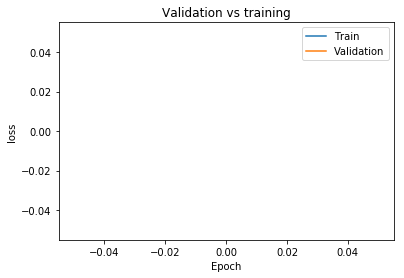

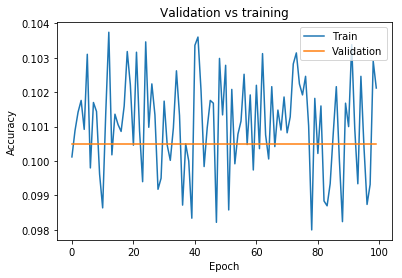

In [0]:
plot_results(result)

In [3]:
clf = NN(Losses.softmax_cross_entropy, Optimizers.SGD, regularizer=Regularizers.l2, reg_lambda=0.001)
clf.add(Layers.Dense(128, input_dim=n))
clf.add(Layers.Dense(96, activation='elu'))
clf.add(Layers.Dense(64, activation='elu'))
clf.add(Layers.Dense(10, activation='softmax'))
epochs = 100
result = clf.fit(x_train,
                 y_train,
                 learning_rate=0.01,
                 batch_size=n,
                 epochs=epochs,
                 print_freq=5,
                 gamma=0.9,
                 validation=(x_val, y_val))

 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 6/100 training loss = nan, training accuracy = 9.866%   validation loss = nan, validation accuracy = 9.56%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 11/100 training loss = nan, training accuracy = 9.978%   validation loss = nan, validation accuracy = 9.56%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 16/100 training loss = nan, training accuracy = 9.818%   validation loss = nan, validation accuracy = 9.56%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 21/100 training loss = nan, training accuracy = 9.956%   validation loss = nan, validation accuracy = 9.56%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 26/100 training loss = nan, training accuracy = 9.815999%   validation loss = nan, validation accuracy = 9.56%   
 [██████████████████████████████████████████████

## 4 - Using batch normalization
<p>
    Next we added batch normalization to all hidden layers. The initial values for batch normalization used throught this notebook is as follows:<br>
    $\gamma = 0.99$<br>
    $\beta = 0.001$<br>
    $\epsilon = 1e^{-5}$
<p>
    The table below summerize results for this experiment
</p>
<table>
    <tr>
        <th>activation</th>
        <th>validation<br>accuracy</th>
        <th>validation<br>loss</th>
    </tr>
    <tr>
        <td>sigmoid</td>
        <td>19.57%</td>
        <td>6.41</td>
    </tr>
    <tr>
        <td>tanh</td>
        <td>19.17%</td>
        <td>7.72</td>
    </tr>
    <tr>
        <td>relu</td>
        <td>30.39%</td>
        <td>4.47</td>
    </tr>
    <tr>
        <td>lrelu</td>
        <td>28.30%</td>
        <td>4.84</td>
    </tr>
    <tr>
        <td>elu</td>
        <td>28.90%</td>
        <td>4.67</td>
    </tr>
</table>

In [0]:
clf = NN(Losses.softmax_cross_entropy, Optimizers.SGD, regularizer=Regularizers.l2, reg_lambda=0.001)
clf.add(Layers.Dense(128, input_dim=n))
clf.add(Layers.Dense(96, activation='sigmoid', batch_norm=(0.99, 0.001, 1e-5)))
clf.add(Layers.Dense(64, activation='sigmoid', batch_norm=(0.99, 0.001, 1e-5)))
clf.add(Layers.Dense(10, activation='softmax'))
epochs = 100
result = clf.fit(x_train,
                 y_train,
                 learning_rate=0.01,
                 batch_size=n,
                 epochs=epochs,
                 print_freq=5,
                 gamma=0.9,
                 validation=(x_val, y_val))


Epoch 0/100
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 5/100 training loss = 8.73330, training accuracy = 14.12200%   validation loss = 8.65131, validation accuracy = 14.42%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 10/100 training loss = 8.56875, training accuracy = 14.65599%   validation loss = 8.47387, validation accuracy = 14.91%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 15/100 training loss = 8.37860, training accuracy = 15.094%   validation loss = 8.30814, validation accuracy = 15.34000%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 20/100 training loss = 8.25527, training accuracy = 15.558%   validation loss = 8.15249, validation accuracy = 15.79000%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 25/100 training loss = 8.06884, training accuracy = 15.928%   validation loss = 8.00509, validation

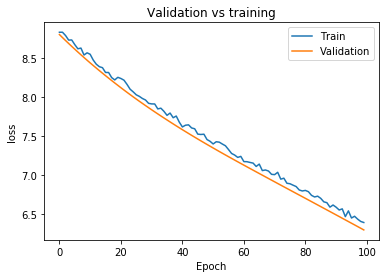

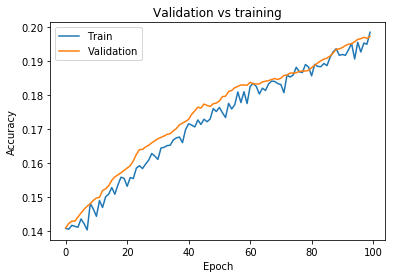

In [0]:
plot_results(result)

In [0]:
clf = NN(Losses.softmax_cross_entropy, Optimizers.SGD, regularizer=Regularizers.l2, reg_lambda=0.001)
clf.add(Layers.Dense(128, input_dim=n))
clf.add(Layers.Dense(96, activation='tanh', batch_norm=(0.99, 0.001, 1e-5)))
clf.add(Layers.Dense(64, activation='tanh', batch_norm=(0.99, 0.001, 1e-5)))
clf.add(Layers.Dense(10, activation='softmax'))
epochs = 100
result = clf.fit(x_train,
                 y_train,
                 learning_rate=0.01,
                 batch_size=n,
                 epochs=epochs,
                 print_freq=5,
                 gamma=0.9,
                 validation=(x_val, y_val))


Epoch 0/100
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 5/100 training loss = 10.8549, training accuracy = 9.406%   validation loss = 10.8006, validation accuracy = 9.11%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 10/100 training loss = 10.6843, training accuracy = 9.852%   validation loss = 10.6013, validation accuracy = 9.700000%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 15/100 training loss = 10.4935, training accuracy = 10.526%   validation loss = 10.4088, validation accuracy = 10.35%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 20/100 training loss = 10.3024, training accuracy = 10.874%   validation loss = 10.2221, validation accuracy = 10.91%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 25/100 training loss = 10.0810, training accuracy = 11.694%   validation loss = 10.0395, validation accuracy 

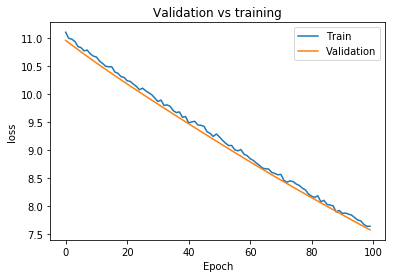

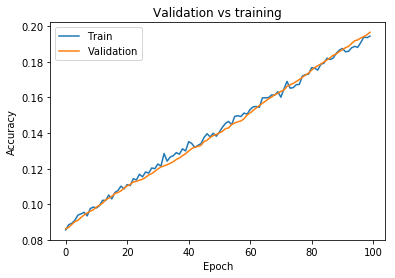

In [0]:
plot_results(result)

In [0]:
clf = NN(Losses.softmax_cross_entropy, Optimizers.SGD, regularizer=Regularizers.l2, reg_lambda=0.001)
clf.add(Layers.Dense(128, input_dim=n))
clf.add(Layers.Dense(96, activation='relu', batch_norm=(0.99, 0.001, 1e-5)))
clf.add(Layers.Dense(64, activation='relu', batch_norm=(0.99, 0.001, 1e-5)))
clf.add(Layers.Dense(10, activation='softmax'))
epochs = 100
result = clf.fit(x_train,
                 y_train,
                 learning_rate=0.01,
                 batch_size=n,
                 epochs=epochs,
                 print_freq=5,
                 gamma=0.9,
                 validation=(x_val, y_val))


Epoch 0/100
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 5/100 training loss = 9.82016, training accuracy = 15.116%   validation loss = 9.82950, validation accuracy = 14.62%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 10/100 training loss = 9.50615, training accuracy = 15.506%   validation loss = 9.45680, validation accuracy = 15.0%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 15/100 training loss = 9.13778, training accuracy = 15.948%   validation loss = 9.07941, validation accuracy = 15.47999%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 20/100 training loss = 8.79024, training accuracy = 16.56799%   validation loss = 8.69899, validation accuracy = 15.9%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 25/100 training loss = 8.43950, training accuracy = 16.396%   validation loss = 8.31749, validation accura

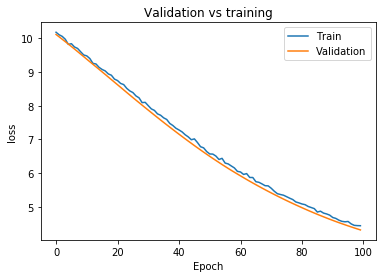

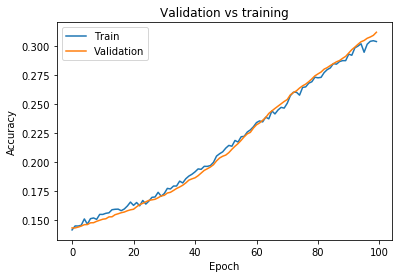

In [0]:
plot_results(result)

In [0]:
clf = NN(Losses.softmax_cross_entropy, Optimizers.SGD, regularizer=Regularizers.l2, reg_lambda=0.001)
clf.add(Layers.Dense(128, input_dim=n))
clf.add(Layers.Dense(96, activation='lrelu', batch_norm=(0.99, 0.001, 1e-5)))
clf.add(Layers.Dense(64, activation='lrelu', batch_norm=(0.99, 0.001, 1e-5)))
clf.add(Layers.Dense(10, activation='softmax'))
epochs = 100
result = clf.fit(x_train,
                 y_train,
                 learning_rate=0.01,
                 batch_size=n,
                 epochs=epochs,
                 print_freq=5,
                 gamma=0.9,
                 validation=(x_val, y_val))


Epoch 0/100
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 5/100 training loss = 10.3208, training accuracy = 8.200000%   validation loss = 10.2066, validation accuracy = 8.469999%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 10/100 training loss = 9.93562, training accuracy = 8.713999%   validation loss = 9.78216, validation accuracy = 9.32%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 15/100 training loss = 9.46579, training accuracy = 9.533999%   validation loss = 9.36940, validation accuracy = 9.98%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 20/100 training loss = 9.07122, training accuracy = 10.526%   validation loss = 8.96793, validation accuracy = 10.74%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 25/100 training loss = 8.69243, training accuracy = 11.44%   validation loss = 8.57681, validation acc

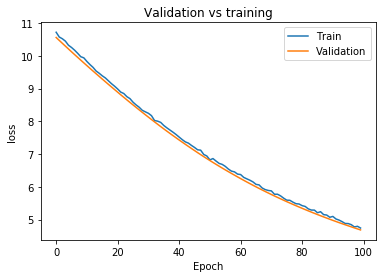

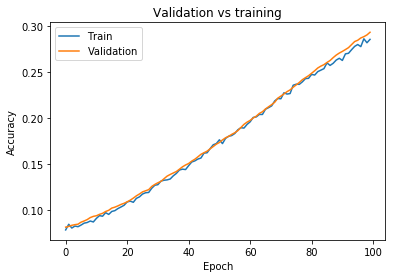

In [0]:
plot_results(result)

In [0]:
clf = NN(Losses.softmax_cross_entropy, Optimizers.SGD, regularizer=Regularizers.l2, reg_lambda=0.001)
clf.add(Layers.Dense(128, input_dim=n))
clf.add(Layers.Dense(96, activation='elu', batch_norm=(0.99, 0.001, 1e-5)))
clf.add(Layers.Dense(64, activation='elu', batch_norm=(0.99, 0.001, 1e-5)))
clf.add(Layers.Dense(10, activation='softmax'))
epochs = 100
result = clf.fit(x_train,
                 y_train,
                 learning_rate=0.01,
                 batch_size=n,
                 epochs=epochs,
                 print_freq=5,
                 gamma=0.9,
                 validation=(x_val, y_val))


Epoch 0/100
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 5/100 training loss = 10.9648, training accuracy = 11.59%   validation loss = 10.7481, validation accuracy = 11.67%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 10/100 training loss = 10.1405, training accuracy = 13.592%   validation loss = 9.90776, validation accuracy = 13.70000%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 15/100 training loss = 9.37439, training accuracy = 15.124%   validation loss = 9.17834, validation accuracy = 15.73%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 20/100 training loss = 8.73562, training accuracy = 16.81799%   validation loss = 8.57382, validation accuracy = 17.19%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 25/100 training loss = 8.24695, training accuracy = 17.612%   validation loss = 8.06648, validation accur

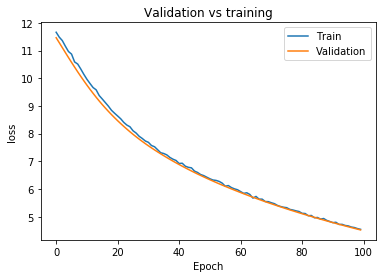

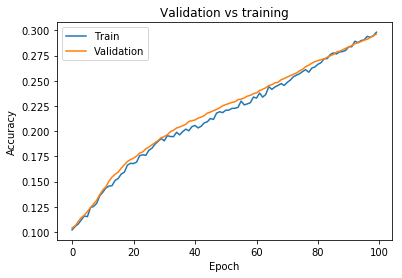

In [0]:
plot_results(result)

## 4 - using RMSProp
<p>
    we repeat the pervious experiment but using RMSProp instead of gradient descent.<br>
    A learning rate decay of 0.9 was used for RMSProp while keeping all other parameters unchaged from pervious experiment<br>
<p>
    The table below summerize results for this experiment
</p>
<table>
    <tr>
        <th>activation</th>
        <th>validation<br>accuracy</th>
        <th>validation<br>loss</th>
    </tr>
    <tr>
        <td>sigmoid</td>
        <td>70.64%</td>
        <td>0.852</td>
    </tr>
    <tr>
        <td>tanh</td>
        <td>71.85%</td>
        <td>0.8517</td>
    </tr>
    <tr>
        <td>relu</td>
        <td>72.32%</td>
        <td>0.8126</td>
    </tr>
    <tr>
        <td><b>lrelu</b></td>
        <td><b>72.72%</b></td>
        <td><b>0.8006</b></td>
    </tr>
    <tr>
        <td>elu</td>
        <td>71.11%</td>
        <td>0.83752</td>
    </tr>
</table>
<p>
    The results above shows that leaky relu did out perform all other activations and therefore is used in our final model.<br>
    RMSProp also performed better than GD with the same guessed initial learning rate and regularization and will also be used in our final model.
</p>

In [0]:
clf = NN(Losses.softmax_cross_entropy, Optimizers.RMSProp, regularizer=Regularizers.l2, reg_lambda=0.001)
clf.add(Layers.Dense(128, input_dim=n))
clf.add(Layers.Dense(96, activation='sigmoid', batch_norm=(0.99, 0.001, 1e-5)))
clf.add(Layers.Dense(64, activation='sigmoid', batch_norm=(0.99, 0.001, 1e-5)))
clf.add(Layers.Dense(10, activation='softmax'))
epochs = 100
result = clf.fit(x_train,
                 y_train,
                 learning_rate=0.01,
                 batch_size=n,
                 epochs=epochs,
                 print_freq=5,
                 gamma=0.0,
                 decay=0.9,
                 validation=(x_val, y_val))


Epoch 0/100
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 5/100 training loss = 4.07604, training accuracy = 22.544%   validation loss = 3.68522, validation accuracy = 22.99%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 10/100 training loss = 2.83181, training accuracy = 28.75599%   validation loss = 2.65802, validation accuracy = 28.73%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 15/100 training loss = 2.24339, training accuracy = 32.74599%   validation loss = 2.13207, validation accuracy = 33.53%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 20/100 training loss = 1.93868, training accuracy = 37.90799%   validation loss = 1.86021, validation accuracy = 38.54%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 25/100 training loss = 1.72129, training accuracy = 43.338%   validation loss = 1.66806, validation acc

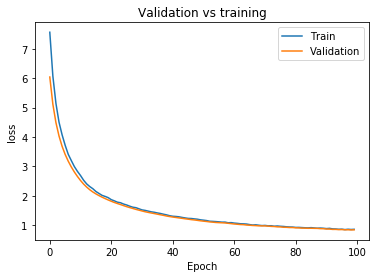

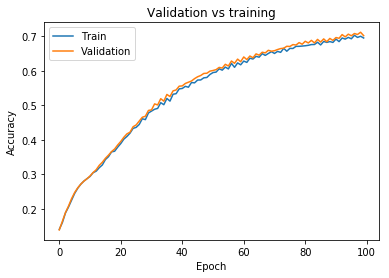

In [0]:
plot_results(result)

In [0]:
clf = NN(Losses.softmax_cross_entropy, Optimizers.RMSProp, regularizer=Regularizers.l2, reg_lambda=0.001)
clf.add(Layers.Dense(128, input_dim=n))
clf.add(Layers.Dense(96, activation='tanh', batch_norm=(0.99, 0.001, 1e-5)))
clf.add(Layers.Dense(64, activation='tanh', batch_norm=(0.99, 0.001, 1e-5)))
clf.add(Layers.Dense(10, activation='softmax'))
epochs = 100
result = clf.fit(x_train,
                 y_train,
                 learning_rate=0.01,
                 batch_size=n,
                 epochs=epochs,
                 print_freq=5,
                 gamma=0.0,
                 decay=0.9,
                 validation=(x_val, y_val))


Epoch 0/100
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 5/100 training loss = 8.79231, training accuracy = 17.048%   validation loss = 8.27394, validation accuracy = 16.36%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 10/100 training loss = 6.27631, training accuracy = 26.21200%   validation loss = 5.93855, validation accuracy = 25.41%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 15/100 training loss = 4.77786, training accuracy = 35.04%   validation loss = 4.52612, validation accuracy = 34.92%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 20/100 training loss = 3.76594, training accuracy = 42.244%   validation loss = 3.68907, validation accuracy = 41.91%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 25/100 training loss = 3.18305, training accuracy = 47.342%   validation loss = 3.11443, validation accuracy

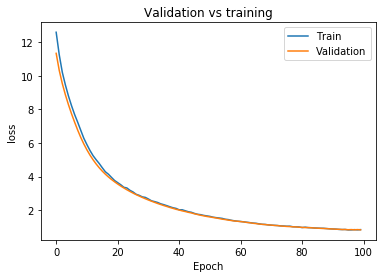

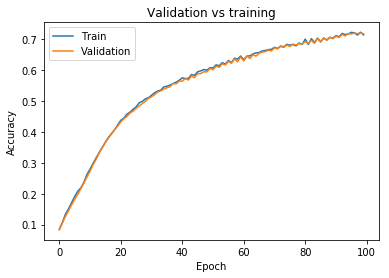

In [0]:
plot_results(result)

In [0]:
clf = NN(Losses.softmax_cross_entropy, Optimizers.RMSProp, regularizer=Regularizers.l2, reg_lambda=0.001)
clf.add(Layers.Dense(128, input_dim=n))
clf.add(Layers.Dense(96, activation='relu', batch_norm=(0.99, 0.001, 1e-5)))
clf.add(Layers.Dense(64, activation='relu', batch_norm=(0.99, 0.001, 1e-5)))
clf.add(Layers.Dense(10, activation='softmax'))
epochs = 100
result = clf.fit(x_train,
                 y_train,
                 learning_rate=0.01,
                 batch_size=n,
                 epochs=epochs,
                 print_freq=5,
                 gamma=0.0,
                 decay=0.9,
                 validation=(x_val, y_val))


Epoch 0/100
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 5/100 training loss = 7.49073, training accuracy = 20.97%   validation loss = 6.95706, validation accuracy = 20.22%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 10/100 training loss = 5.09434, training accuracy = 32.488%   validation loss = 4.75683, validation accuracy = 31.38000%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 15/100 training loss = 3.77921, training accuracy = 40.222%   validation loss = 3.61208, validation accuracy = 39.83%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 20/100 training loss = 3.08806, training accuracy = 45.9%   validation loss = 2.96585, validation accuracy = 46.04%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 25/100 training loss = 2.60968, training accuracy = 49.612%   validation loss = 2.53550, validation accuracy 

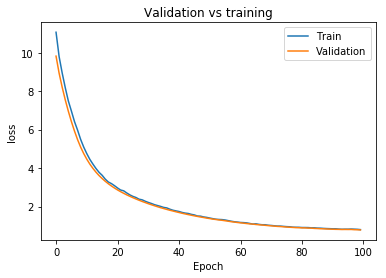

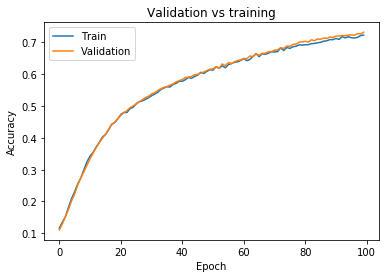

In [0]:
plot_results(result)

In [0]:
clf = NN(Losses.softmax_cross_entropy, Optimizers.RMSProp, regularizer=Regularizers.l2, reg_lambda=0.001)
clf.add(Layers.Dense(128, input_dim=n))
clf.add(Layers.Dense(96, activation='lrelu', batch_norm=(0.99, 0.001, 1e-5)))
clf.add(Layers.Dense(64, activation='lrelu', batch_norm=(0.99, 0.001, 1e-5)))
clf.add(Layers.Dense(10, activation='softmax'))
epochs = 100
result = clf.fit(x_train,
                 y_train,
                 learning_rate=0.01,
                 batch_size=n,
                 epochs=epochs,
                 print_freq=5,
                 gamma=0.0,
                 decay=0.9,
                 validation=(x_val, y_val))


Epoch 0/100
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 5/100 training loss = 9.40184, training accuracy = 14.654%   validation loss = 8.54167, validation accuracy = 14.77%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 10/100 training loss = 6.14825, training accuracy = 28.242%   validation loss = 5.75083, validation accuracy = 28.54999%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 15/100 training loss = 4.63112, training accuracy = 37.532%   validation loss = 4.41690, validation accuracy = 38.08000%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 20/100 training loss = 3.71391, training accuracy = 43.66999%   validation loss = 3.59244, validation accuracy = 44.07%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 25/100 training loss = 3.03500, training accuracy = 48.546%   validation loss = 2.99116, validation a

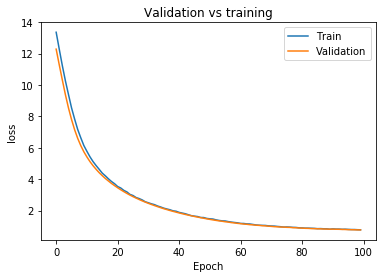

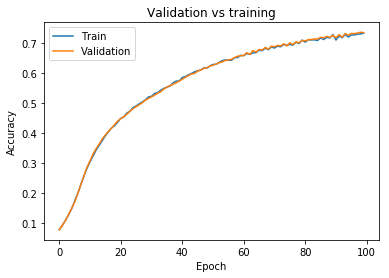

In [0]:
plot_results(result)

In [0]:
clf = NN(Losses.softmax_cross_entropy, Optimizers.RMSProp, regularizer=Regularizers.l2, reg_lambda=0.001)
clf.add(Layers.Dense(128, input_dim=n))
clf.add(Layers.Dense(96, activation='elu', batch_norm=(0.99, 0.001, 1e-5)))
clf.add(Layers.Dense(64, activation='elu', batch_norm=(0.99, 0.001, 1e-5)))
clf.add(Layers.Dense(10, activation='softmax'))
epochs = 100
result = clf.fit(x_train,
                 y_train,
                 learning_rate=0.01,
                 batch_size=n,
                 epochs=epochs,
                 print_freq=5,
                 gamma=0.0,
                 decay=0.9,
                 validation=(x_val, y_val))


Epoch 0/100
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 5/100 training loss = 8.55625, training accuracy = 15.826%   validation loss = 7.82367, validation accuracy = 16.12%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 10/100 training loss = 5.94379, training accuracy = 25.88%   validation loss = 5.53656, validation accuracy = 26.21%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 15/100 training loss = 4.52342, training accuracy = 34.146%   validation loss = 4.27381, validation accuracy = 34.77%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 20/100 training loss = 3.64807, training accuracy = 41.452%   validation loss = 3.50572, validation accuracy = 41.5%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 25/100 training loss = 3.06686, training accuracy = 46.206%   validation loss = 2.97375, validation accuracy = 

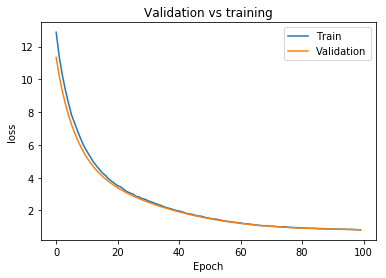

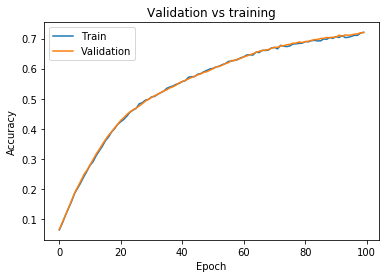

In [0]:
plot_results(result)

## 5- Batch size
<p>
    For this experiment we did a grid search to find best batch size to use.<br>
    To get things working a bit faster, we used only 5 epochs for each search point here.<br>
    The results for this experiment are listed below.
</p>
<table>
    <tr>
        <th>Batch<br>size</th>
        <th>validation<br>accuracy</th>
        <th>validation<br>loss</th>
    </tr>
    <tr>
        <td>1</td>
        <td>11.76%</td>
        <td>2.4039</td>
    </tr>
    <tr>
        <td>16</td>
        <td>84.57%</td>
        <td>0.4386</td>
    </tr>
    <tr>
        <td>32</td>
        <td>85.69%</td>
        <td>0.4030</td>
    </tr>
    <tr>
        <td>64</td>
        <td>86.02%</td>
        <td>0.3929</td>
    </tr>
    <tr>
        <td><b>128</b></td>
        <td><b>86.58%</b></td>
        <td><b>0.37525</b></td>
    </tr>
    <tr>
        <td>256</td>
        <td>83.23%</td>
        <td>0.4592</td>
    </tr>
    <tr>
        <td>512</td>
        <td>79.68%</td>
        <td>0.5620</td>
    </tr>
    <tr>
        <td>1024</td>
        <td>76.21%</td>
        <td>0.6639</td>
    </tr>
    <tr>
        <td>2048</td>
        <td>62.51%</td>
        <td>1.3293</td>
    </tr>
    <tr>
        <td>8192</td>
        <td>49.92%</td>
        <td>2.4382</td>
    </tr>
    <tr>
        <td>16384</td>
        <td>47.57%</td>
        <td>3.2108</td>
    </tr>
    <tr>
        <td>50000</td>
        <td>19.54%</td>
        <td>6.9090</td>
    </tr>
</table>
<p>
    From the table above, we can clearly see that batch size of 128 out performed all other values. Therefore, batch size of 128 will be used in our final model.
</p>

In [0]:
n_search = 100
batch_sizes = [2**i for i in range(4, 15)]
batch_sizes.append(50000)
batch_sizes.append(1)
batch_sizes = sorted(batch_sizes)
keys = ['batch_size', 'val_acc', 'val_loss']
results = {}
for key in keys:
    results[key] = []
for batch_size in batch_sizes:
    print('batch size = {}'.format(batch_size))
    clf = NN(Losses.softmax_cross_entropy, Optimizers.RMSProp, regularizer=Regularizers.l2, reg_lambda=0.001)
    clf.add(Layers.Dense(128, input_dim=n))
    clf.add(Layers.Dense(96, activation='lrelu', batch_norm=(0.99, 0.001, 1e-5)))
    clf.add(Layers.Dense(64, activation='lrelu', batch_norm=(0.99, 0.001, 1e-5)))
    clf.add(Layers.Dense(10, activation='softmax'))
    epochs = 5
    result = clf.fit(x_train,
                   y_train,
                   learning_rate=0.01,
                   batch_size=batch_size,
                   epochs=epochs,
                   print_freq=1,
                   gamma=0.0,
                   decay=0.9,
                   validation=(x_val, y_val))
    loss, acc, val_loss, val_acc = result['Loss'], result['Accuracy'], result['Val Loss'], result['Val Accuracy']
    results['batch_size'].append(batch_size)
    results['val_acc'].append(val_acc)
    results['val_loss'].append(val_loss)

batch size = 1

Epoch 0/5
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 1/5 training loss = 2.31911, training accuracy = 9.700000%   validation loss = 2.37609, validation accuracy = 9.379999%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 2/5 training loss = 2.31869, training accuracy = 10.404%   validation loss = 2.62296, validation accuracy = 10.45999%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 3/5 training loss = 2.31934, training accuracy = 10.00199%   validation loss = 2.89896, validation accuracy = 9.84%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 4/5 training loss = 2.31890, training accuracy = 12.052%   validation loss = 2.40391, validation accuracy = 11.76%   
 [████████████████████████████████████████████████████████████] 100.0%  

batch size = 16

Epoch 0/5
 [████████████████████████████████████████████████████████████] 100.0%  
Epo

In [0]:
index = np.argmax(np.asarray(results['val_acc'])[:,-1])
print(np.asarray(results['val_acc'])[index,-1])
print(np.asarray(results['batch_size'])[index])

0.8633
128


## 6- Learning rate and weight decay
<p>
    In the following experiment, we first implemented a coarse random search to select hyper paramters for learning rate and regularization. Followed by multiple finer searches to obtain more robust values. All searches happened in log space.
</p>
<p>We experimented with the following regularizations:</p>
<h3> a) L2 regularization</h3>
<p>
    Best learning rate = $10^{-1.657}$<br>
    Best L2 paramater $\gamma=10^{-4.955}$<br>
    Validation accuracy = 88.24%    
</p>
<h3> b) L1 regularization</h3>
<p>
    <b>Best learning rate = $10^{-2.456}$<br></b>
    <b>Best L2 paramater $\gamma=10^{-4.96}$<br></b>
    <b>Validation accuracy = 88.72%<br><br></b>
    We used these paramaters in our final model
</p>


### L2 regularization experiments

In [9]:
n_search = 100
keys = ['lr', 'reg', 'val_acc', 'val_loss']
results = {}
for key in keys:
    results[key] = []
for i in range(n_search):
    lr = 10**uniform(-6, 1)
    reg = 10**uniform(-6, 1)
    print('learning rate = {}, weight decay = {}'.format(lr, reg))
    clf = NN(Losses.softmax_cross_entropy, Optimizers.RMSProp, regularizer=Regularizers.l2, reg_lambda=reg)
    clf.add(Layers.Dense(128, input_dim=n))
    clf.add(Layers.Dense(96, activation='lrelu', batch_norm=(0.99, 0.001, 1e-5)))
    clf.add(Layers.Dense(64, activation='lrelu', batch_norm=(0.99, 0.001, 1e-5)))
    clf.add(Layers.Dense(10, activation='softmax'))
    epochs = 5
    result = clf.fit(x_train,
                   y_train,
                   learning_rate=lr,
                   batch_size=128,
                   epochs=epochs,
                   print_freq=1,
                   gamma=0.0,
                   decay=0.9,
                   validation=(x_val, y_val))
    loss, acc, val_loss, val_acc = result['Loss'], result['Accuracy'], result['Val Loss'], result['Val Accuracy']
    results['lr'].append(lr)
    results['reg'].append(reg)
    results['val_acc'].append(val_acc)
    results['val_loss'].append(val_loss)

learning rate = 1.4451886482172354, weight decay = 0.0004741063826807966
 [██████------------------------------------------------------] 10.2%  

C:\Users\Owner\Deep-learning\Deep learning\DeepLearning.py:156: RuntimeWarning: invalid value encountered in true_divide
  return exps / np.sum(exps, axis=1, keepdims=True)
C:\Users\Owner\Deep-learning\Deep learning\DeepLearning.py:122: RuntimeWarning: invalid value encountered in greater
  return x * (x > 0) + 0.01 * x * (x <= 0)
C:\Users\Owner\Deep-learning\Deep learning\DeepLearning.py:122: RuntimeWarning: invalid value encountered in less_equal
  return x * (x > 0) + 0.01 * x * (x <= 0)
C:\Users\Owner\Deep-learning\Deep learning\DeepLearning.py:130: RuntimeWarning: invalid value encountered in greater
  return 1 * (x > 0) + 0.01 * (x <= 0)
C:\Users\Owner\Deep-learning\Deep learning\DeepLearning.py:130: RuntimeWarning: invalid value encountered in less_equal
  return 1 * (x > 0) + 0.01 * (x <= 0)


 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 1/5 training loss = nan, training accuracy = 9.916%   validation loss = nan, validation accuracy = 9.77%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 2/5 training loss = nan, training accuracy = 9.966%   validation loss = nan, validation accuracy = 9.77%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 3/5 training loss = nan, training accuracy = 10.08%   validation loss = nan, validation accuracy = 9.77%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 4/5 training loss = nan, training accuracy = 9.751999%   validation loss = nan, validation accuracy = 9.77%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 5/5 training loss = nan, training accuracy = 9.44%   validation loss = nan, validation accuracy = 9.77%   


learning rate = 8.174686449719692, weight decay = 2.720422250

 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 1/5 training loss = 2.39015, training accuracy = 10.418%   validation loss = 2.35029, validation accuracy = 9.49%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 2/5 training loss = 2.33639, training accuracy = 10.01400%   validation loss = 2.37956, validation accuracy = 10.02%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 3/5 training loss = 2.33588, training accuracy = 10.152%   validation loss = 2.40883, validation accuracy = 10.20999%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 4/5 training loss = 2.33961, training accuracy = 10.542%   validation loss = 2.33335, validation accuracy = 10.29999%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 5/5 training loss = 2.33938, training accuracy = 8.926%   validation loss = 2.35511, validation accuracy = 8.97%   


learning

 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 5/5 training loss = 11.4504, training accuracy = 8.924%   validation loss = 11.4605, validation accuracy = 8.38%   


learning rate = 0.00018588634671717894, weight decay = 0.0017503462975726437
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 1/5 training loss = 9.42779, training accuracy = 17.702%   validation loss = 8.16451, validation accuracy = 18.63%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 2/5 training loss = 7.16882, training accuracy = 25.08199%   validation loss = 6.02297, validation accuracy = 25.61%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 3/5 training loss = 5.27811, training accuracy = 32.872%   validation loss = 4.42878, validation accuracy = 33.32%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 4/5 training loss = 3.97631, training accuracy = 40.73

 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 4/5 training loss = nan, training accuracy = 9.533999%   validation loss = nan, validation accuracy = 9.77%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 5/5 training loss = nan, training accuracy = 9.856%   validation loss = nan, validation accuracy = 9.77%   


learning rate = 2.804935126172274, weight decay = 1.0957610163382574
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 1/5 training loss = nan, training accuracy = 9.608%   validation loss = nan, validation accuracy = 9.77%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 2/5 training loss = nan, training accuracy = 9.766%   validation loss = nan, validation accuracy = 9.77%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 3/5 training loss = nan, training accuracy = 9.674000%   validation loss = nan, validation accuracy

 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 2/5 training loss = 1.70924, training accuracy = 45.844%   validation loss = 2.21709, validation accuracy = 45.89%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 3/5 training loss = 1.88600, training accuracy = 16.614%   validation loss = 4.16157, validation accuracy = 17.01%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 4/5 training loss = 2.03250, training accuracy = 53.152%   validation loss = 1.24382, validation accuracy = 53.23999%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 5/5 training loss = 1.78666, training accuracy = 38.79%   validation loss = 1.70855, validation accuracy = 39.14%   


learning rate = 0.0021716291852839093, weight decay = 1.1129963961070486
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 1/5 training loss = 4.25345, training accuracy = 56.058%

 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 5/5 training loss = 2.99640, training accuracy = 51.266%   validation loss = 2.61307, validation accuracy = 51.25999%   


learning rate = 0.25842187968154107, weight decay = 0.6802815447350057
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 1/5 training loss = 2.37659, training accuracy = 12.52000%   validation loss = 2.35891, validation accuracy = 11.68%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 2/5 training loss = 2.35383, training accuracy = 2.63%   validation loss = 2.37504, validation accuracy = 2.62%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 3/5 training loss = 2.35940, training accuracy = 7.249999%   validation loss = 2.30723, validation accuracy = 6.98%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 4/5 training loss = 2.35826, training accuracy = 10.484% 

 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 3/5 training loss = 2.05083, training accuracy = 29.036%   validation loss = 1.83044, validation accuracy = 28.68%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 4/5 training loss = 2.02872, training accuracy = 23.528%   validation loss = 1.94160, validation accuracy = 24.44%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 5/5 training loss = 1.99270, training accuracy = 22.178%   validation loss = 2.11920, validation accuracy = 21.75%   


learning rate = 0.0646593119935338, weight decay = 3.209824497057418
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 1/5 training loss = 2.12395, training accuracy = 25.648%   validation loss = 2.07173, validation accuracy = 25.75%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 2/5 training loss = 2.17168, training accuracy = 9.818%   vali

 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 2/5 training loss = 0.50131, training accuracy = 84.58%   validation loss = 0.46436, validation accuracy = 84.17%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 3/5 training loss = 0.48886, training accuracy = 83.176%   validation loss = 0.48451, validation accuracy = 82.75%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 4/5 training loss = 0.48822, training accuracy = 83.598%   validation loss = 0.48980, validation accuracy = 83.36%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 5/5 training loss = 0.48117, training accuracy = 83.98%   validation loss = 0.47392, validation accuracy = 83.67%   


learning rate = 7.133139820881403e-05, weight decay = 4.685084928711081
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 1/5 training loss = 10.4770, training accuracy = 13.028%   va

 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 1/5 training loss = 0.95854, training accuracy = 80.784%   validation loss = 0.53803, validation accuracy = 80.04%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 2/5 training loss = 0.47293, training accuracy = 83.334%   validation loss = 0.48798, validation accuracy = 82.33%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 3/5 training loss = 0.40581, training accuracy = 87.004%   validation loss = 0.38843, validation accuracy = 85.92%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 4/5 training loss = 0.37936, training accuracy = 87.032%   validation loss = 0.39694, validation accuracy = 85.22%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 5/5 training loss = 0.35608, training accuracy = 88.19200%   validation loss = 0.36564, validation accuracy = 86.56%   


learning ra

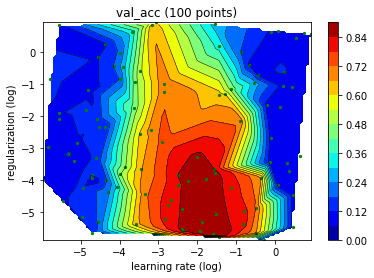

In [0]:
plot_contour(np.log10(np.asarray(results['lr'])),
             np.log10(np.asarray(results['reg'])),
             np.asarray(results['val_acc'])[:,-1],
             'learning rate (log)',
             'regularization (log)',
             'val_acc (%d points)' % 100 )

In [0]:
n_search = 100
keys = ['lr', 'reg', 'val_acc', 'val_loss']
results = {}
for key in keys:
    results[key] = []
for i in range(n_search):
    lr = 10**uniform(-2.5, -1.1)
    reg = 10**uniform(-5.5, -2.5)
    print('{}- learning rate = {}, weight decay = {}'.format(i, lr, reg))
    clf = NN(Losses.softmax_cross_entropy, Optimizers.RMSProp, regularizer=Regularizers.l2, reg_lambda=reg)
    clf.add(Layers.Dense(128, input_dim=n))
    clf.add(Layers.Dense(96, activation='lrelu', batch_norm=(0.99, 0.001, 1e-5)))
    clf.add(Layers.Dense(64, activation='lrelu', batch_norm=(0.99, 0.001, 1e-5)))
    clf.add(Layers.Dense(10, activation='softmax'))
    epochs = 5
    result = clf.fit(x_train,
                   y_train,
                   learning_rate=lr,
                   batch_size=128,
                   epochs=epochs,
                   print_freq=1,
                   gamma=0.0,
                   decay=0.9,
                   validation=(x_val, y_val))
    loss, acc, val_loss, val_acc = result['Loss'], result['Accuracy'], result['Val Loss'], result['Val Accuracy']
    results['lr'].append(lr)
    results['reg'].append(reg)
    results['val_acc'].append(val_acc)
    results['val_loss'].append(val_loss)

0- learning rate = 0.07826151337966383, weight decay = 0.00013476000099073992

Epoch 0/5
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 1/5 training loss = 0.70536, training accuracy = 76.878%   validation loss = 0.65714, validation accuracy = 75.77000%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 2/5 training loss = 0.49485, training accuracy = 84.294%   validation loss = 0.47332, validation accuracy = 83.50999%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 3/5 training loss = 0.48094, training accuracy = 85.2%   validation loss = 0.43279, validation accuracy = 84.50999%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 4/5 training loss = 0.48192, training accuracy = 84.828%   validation loss = 0.44102, validation accuracy = 84.58%   
 [████████████████████████████████████████████████████████████] 100.0%  

1- learning rate = 0.018804926535446492, w

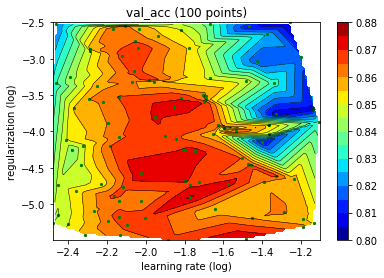

In [0]:
plot_contour(np.log10(np.asarray(results['lr'])),
             np.log10(np.asarray(results['reg'])),
             np.asarray(results['val_acc'])[:,-1],
             'learning rate (log)',
             'regularization (log)',
             'val_acc (%d points)' % 100 )

In [0]:
n_search = 100
keys = ['lr', 'reg', 'val_acc', 'val_loss']
results = {}
for key in keys:
    results[key] = []
for i in range(n_search):
    lr = 10**uniform(-2.1, -1.5)
    reg = 10**uniform(-5.1, -3.6)
    print('{}- learning rate = {}, weight decay = {}'.format(i, lr, reg))
    clf = NN(Losses.softmax_cross_entropy, Optimizers.RMSProp, regularizer=Regularizers.l2, reg_lambda=reg)
    clf.add(Layers.Dense(128, input_dim=n))
    clf.add(Layers.Dense(96, activation='lrelu', batch_norm=(0.99, 0.001, 1e-5)))
    clf.add(Layers.Dense(64, activation='lrelu', batch_norm=(0.99, 0.001, 1e-5)))
    clf.add(Layers.Dense(10, activation='softmax'))
    epochs = 5
    result = clf.fit(x_train,
                   y_train,
                   learning_rate=lr,
                   batch_size=128,
                   epochs=epochs,
                   print_freq=1,
                   gamma=0.0,
                   decay=0.9,
                   validation=(x_val, y_val))
    loss, acc, val_loss, val_acc = result['Loss'], result['Accuracy'], result['Val Loss'], result['Val Accuracy']
    results['lr'].append(lr)
    results['reg'].append(reg)
    results['val_acc'].append(val_acc)
    results['val_loss'].append(val_loss)

0- learning rate = 0.016994788144309735, weight decay = 2.4296638378020858e-05

Epoch 0/5
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 1/5 training loss = 0.85467, training accuracy = 83.994%   validation loss = 0.48180, validation accuracy = 82.62%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 2/5 training loss = 0.43565, training accuracy = 85.898%   validation loss = 0.42120, validation accuracy = 85.15%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 3/5 training loss = 0.38767, training accuracy = 87.17%   validation loss = 0.39246, validation accuracy = 86.02%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 4/5 training loss = 0.36164, training accuracy = 87.89200%   validation loss = 0.38636, validation accuracy = 86.41%   
 [████████████████████████████████████████████████████████████] 100.0%  

1- learning rate = 0.015233109387755782, weight

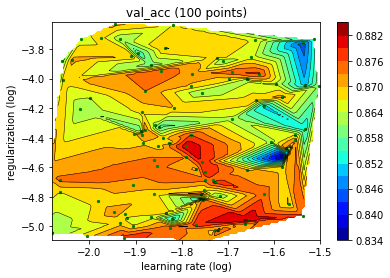

In [0]:
plot_contour(np.log10(np.asarray(results['lr'])),
             np.log10(np.asarray(results['reg'])),
             np.asarray(results['val_acc'])[:,-1],
             'learning rate (log)',
             'regularization (log)',
             'val_acc (%d points)' % 100 )

In [0]:
index = np.argmax(np.asarray(results['val_acc'])[:,-1])
print(np.asarray(results['lr'])[index])
print(np.asarray(results['reg'])[index])
print(np.asarray(results['val_acc'])[index,-1])

0.022053841625651306
1.1082483721029315e-05
0.8824


### L1 regularization experiments

In [0]:
n_search = 100
keys = ['lr', 'reg', 'val_acc', 'val_loss']
results = {}
for key in keys:
    results[key] = []
for i in range(n_search):
    lr = 10**uniform(-6, 1)
    reg = 10**uniform(-6, 1)
    print('learning rate = {}, weight decay = {}'.format(lr, reg))
    clf = NN(Losses.softmax_cross_entropy, Optimizers.RMSProp, regularizer=Regularizers.l1, reg_lambda=reg)
    clf.add(Layers.Dense(128, input_dim=n))
    clf.add(Layers.Dense(96, activation='lrelu', batch_norm=(0.99, 0.001, 1e-5)))
    clf.add(Layers.Dense(64, activation='lrelu', batch_norm=(0.99, 0.001, 1e-5)))
    clf.add(Layers.Dense(10, activation='softmax'))
    epochs = 5
    result = clf.fit(x_train,
                   y_train,
                   learning_rate=lr,
                   batch_size=128,
                   epochs=epochs,
                   print_freq=1,
                   gamma=0.0,
                   decay=0.9,
                   validation=(x_val, y_val))
    loss, acc, val_loss, val_acc = result['Loss'], result['Accuracy'], result['Val Loss'], result['Val Accuracy']
    results['lr'].append(lr)
    results['reg'].append(reg)
    results['val_acc'].append(val_acc)
    results['val_loss'].append(val_loss)

learning rate = 0.0002961530687461269, weight decay = 1.160217391699026

Epoch 0/5
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 1/5 training loss = 9.67958, training accuracy = 15.40400%   validation loss = 8.38291, validation accuracy = 15.24%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 2/5 training loss = 7.00114, training accuracy = 21.14%   validation loss = 5.81897, validation accuracy = 20.54%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 3/5 training loss = 4.84791, training accuracy = 29.194%   validation loss = 4.05634, validation accuracy = 28.98%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 4/5 training loss = 3.45536, training accuracy = 35.788%   validation loss = 2.92272, validation accuracy = 35.62000%   
 [████████████████████████████████████████████████████████████] 100.0%  

learning rate = 0.016370167005079414, weight decay 

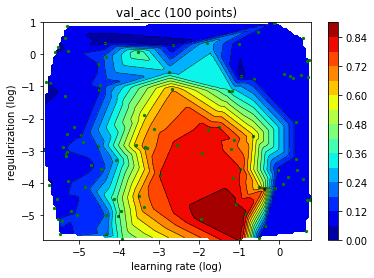

In [0]:
plot_contour(np.log10(np.asarray(results['lr'])),
             np.log10(np.asarray(results['reg'])),
             np.asarray(results['val_acc'])[:,-1],
             'learning rate (log)',
             'regularization (log)',
             'val_acc (%d points)' % 100 )

In [0]:
n_search = 100
keys = ['lr', 'reg', 'val_acc', 'val_loss']
results = {}
for key in keys:
    results[key] = []
for i in range(n_search):
    lr = 10**uniform(-3, -0.75)
    reg = 10**uniform(-6, -4)
    print('learning rate = {}, weight decay = {}'.format(lr, reg))
    clf = NN(Losses.softmax_cross_entropy, Optimizers.RMSProp, regularizer=Regularizers.l1, reg_lambda=reg)
    clf.add(Layers.Dense(128, input_dim=n))
    clf.add(Layers.Dense(96, activation='lrelu', batch_norm=(0.99, 0.001, 1e-5)))
    clf.add(Layers.Dense(64, activation='lrelu', batch_norm=(0.99, 0.001, 1e-5)))
    clf.add(Layers.Dense(10, activation='softmax'))
    epochs = 5
    result = clf.fit(x_train,
                   y_train,
                   learning_rate=lr,
                   batch_size=128,
                   epochs=epochs,
                   print_freq=1,
                   gamma=0.0,
                   decay=0.9,
                   validation=(x_val, y_val))
    loss, acc, val_loss, val_acc = result['Loss'], result['Accuracy'], result['Val Loss'], result['Val Accuracy']
    results['lr'].append(lr)
    results['reg'].append(reg)
    results['val_acc'].append(val_acc)
    results['val_loss'].append(val_loss)

learning rate = 0.09847069594503419, weight decay = 8.262255532016645e-05

Epoch 0/5
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 1/5 training loss = 0.71076, training accuracy = 81.096%   validation loss = 0.54938, validation accuracy = 80.52%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 2/5 training loss = 0.51345, training accuracy = 80.232%   validation loss = 0.57892, validation accuracy = 80.02%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 3/5 training loss = 0.48822, training accuracy = 84.036%   validation loss = 0.50868, validation accuracy = 83.15%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 4/5 training loss = 0.48565, training accuracy = 84.796%   validation loss = 0.46815, validation accuracy = 83.45%   
 [████████████████████████████████████████████████████████████] 100.0%  

learning rate = 0.12465659155799472, weight decay = 7

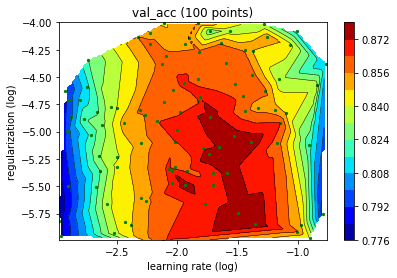

In [0]:
plot_contour(np.log10(np.asarray(results['lr'])),
             np.log10(np.asarray(results['reg'])),
             np.asarray(results['val_acc'])[:,-1],
             'learning rate (log)',
             'regularization (log)',
             'val_acc (%d points)' % 100 )

In [0]:
n_search = 100
keys = ['lr', 'reg', 'val_acc', 'val_loss']
results = {}
for key in keys:
    results[key] = []
for i in range(n_search):
    lr = 10**uniform(-2.1, -1.25)
    reg = 10**uniform(-6, -4.75)
    print('learning rate = {}, weight decay = {}'.format(lr, reg))
    clf = NN(Losses.softmax_cross_entropy, Optimizers.RMSProp, regularizer=Regularizers.l1, reg_lambda=reg)
    clf.add(Layers.Dense(128, input_dim=n))
    clf.add(Layers.Dense(96, activation='lrelu', batch_norm=(0.99, 0.001, 1e-5)))
    clf.add(Layers.Dense(64, activation='lrelu', batch_norm=(0.99, 0.001, 1e-5)))
    clf.add(Layers.Dense(10, activation='softmax'))
    epochs = 5
    result = clf.fit(x_train,
                   y_train,
                   learning_rate=lr,
                   batch_size=128,
                   epochs=epochs,
                   print_freq=1,
                   gamma=0.0,
                   decay=0.9,
                   validation=(x_val, y_val))
    loss, acc, val_loss, val_acc = result['Loss'], result['Accuracy'], result['Val Loss'], result['Val Accuracy']
    results['lr'].append(lr)
    results['reg'].append(reg)
    results['val_acc'].append(val_acc)
    results['val_loss'].append(val_loss)

learning rate = 0.013912486791270471, weight decay = 1.3071325468927367e-05

Epoch 0/5
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 1/5 training loss = 0.98701, training accuracy = 83.514%   validation loss = 0.51326, validation accuracy = 81.78%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 2/5 training loss = 0.44314, training accuracy = 86.578%   validation loss = 0.44025, validation accuracy = 84.25%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 3/5 training loss = 0.38999, training accuracy = 86.402%   validation loss = 0.41008, validation accuracy = 85.08%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 4/5 training loss = 0.36364, training accuracy = 87.654%   validation loss = 0.38553, validation accuracy = 85.95%   
 [████████████████████████████████████████████████████████████] 100.0%  

learning rate = 0.03608527059748547, weight decay =

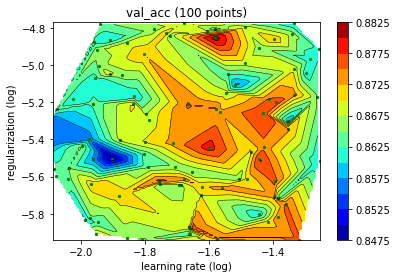

In [0]:
plot_contour(np.log10(np.asarray(results['lr'])),
             np.log10(np.asarray(results['reg'])),
             np.asarray(results['val_acc'])[:,-1],
             'learning rate (log)',
             'regularization (log)',
             'val_acc (%d points)' % 100 )

In [0]:
n_search = 100
keys = ['lr', 'reg', 'val_acc', 'val_loss']
results = {}
for key in keys:
    results[key] = []
for i in range(n_search):
    lr = 10**uniform(-2.6, -2.4)
    reg = 10**uniform(-5.0, -4.6)
    print('learning rate = {}, weight decay = {}'.format(lr, reg))
    clf = NN(Losses.softmax_cross_entropy, Optimizers.RMSProp, regularizer=Regularizers.l1, reg_lambda=reg)
    clf.add(Layers.Dense(128, input_dim=n))
    clf.add(Layers.Dense(96, activation='lrelu', batch_norm=(0.99, 0.001, 1e-5)))
    clf.add(Layers.Dense(64, activation='lrelu', batch_norm=(0.99, 0.001, 1e-5)))
    clf.add(Layers.Dense(10, activation='softmax'))
    epochs = 10
    result = clf.fit(x_train,
                   y_train,
                   learning_rate=lr,
                   batch_size=128,
                   epochs=epochs,
                   print_freq=1,
                   gamma=0.0,
                   decay=0.99,
                   validation=(x_val, y_val))
    loss, acc, val_loss, val_acc = result['Loss'], result['Accuracy'], result['Val Loss'], result['Val Accuracy']
    results['lr'].append(lr)
    results['reg'].append(reg)
    results['val_acc'].append(val_acc)
    results['val_loss'].append(val_loss)

learning rate = 0.0025687514794748632, weight decay = 1.8432860062018436e-05
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 1/10 training loss = 1.91270, training accuracy = 72.94%   validation loss = 0.94030, validation accuracy = 71.58%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 2/10 training loss = 0.77133, training accuracy = 78.056%   validation loss = 0.65621, validation accuracy = 77.38000%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 3/10 training loss = 0.60578, training accuracy = 81.318%   validation loss = 0.55096, validation accuracy = 80.94%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 4/10 training loss = 0.51947, training accuracy = 83.438%   validation loss = 0.49543, validation accuracy = 82.86%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 5/10 training loss = 0.47286, training accuracy = 

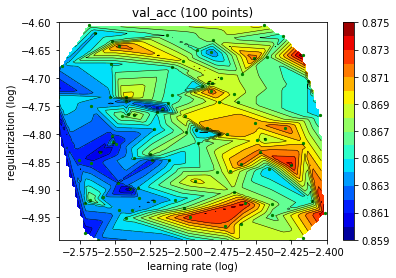

In [0]:
plot_contour(np.log10(np.asarray(results['lr'])),
             np.log10(np.asarray(results['reg'])),
             np.asarray(results['val_acc'])[:,-1],
             'learning rate (log)',
             'regularization (log)',
             'val_acc (%d points)' % 100 )

In [0]:
n_search = 100
keys = ['lr', 'reg', 'val_acc', 'val_loss']
results = {}
for key in keys:
    results[key] = []
for i in range(n_search):
    lr = 10**uniform(-2.5, -2.45)
    reg = 10**uniform(-5, -4.9)
    print('learning rate = {}, weight decay = {}'.format(lr, reg))
    clf = NN(Losses.softmax_cross_entropy, Optimizers.RMSProp, regularizer=Regularizers.l1, reg_lambda=reg)
    clf.add(Layers.Dense(128, input_dim=n))
    clf.add(Layers.Dense(96, activation='lrelu', batch_norm=(0.99, 0.001, 1e-5)))
    clf.add(Layers.Dense(64, activation='lrelu', batch_norm=(0.99, 0.001, 1e-5)))
    clf.add(Layers.Dense(10, activation='softmax'))
    epochs = 10
    result = clf.fit(x_train,
                   y_train,
                   learning_rate=lr,
                   batch_size=128,
                   epochs=epochs,
                   print_freq=1,
                   gamma=0.0,
                   decay=0.99,
                   validation=(x_val, y_val))
    loss, acc, val_loss, val_acc = result['Loss'], result['Accuracy'], result['Val Loss'], result['Val Accuracy']
    results['lr'].append(lr)
    results['reg'].append(reg)
    results['val_acc'].append(val_acc)
    results['val_loss'].append(val_loss)

learning rate = 0.003260133153298763, weight decay = 1.0612559227728254e-05
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 1/10 training loss = 1.65733, training accuracy = 72.904%   validation loss = 0.84652, validation accuracy = 71.69%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 2/10 training loss = 0.71015, training accuracy = 79.24799%   validation loss = 0.62156, validation accuracy = 78.13%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 3/10 training loss = 0.58248, training accuracy = 81.28999%   validation loss = 0.53290, validation accuracy = 81.12%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 4/10 training loss = 0.50589, training accuracy = 83.77799%   validation loss = 0.49070, validation accuracy = 82.39999%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 5/10 training loss = 0.46079, training accur

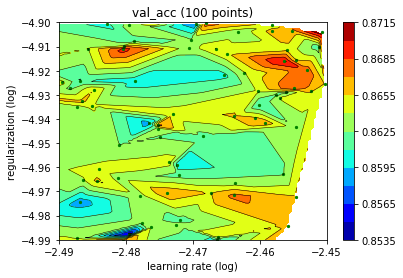

In [0]:
plot_contour(np.log10(np.asarray(results['lr'])),
             np.log10(np.asarray(results['reg'])),
             np.asarray(results['val_acc'])[:,-1],
             'learning rate (log)',
             'regularization (log)',
             'val_acc (%d points)' % 100 )

In [0]:
index = np.argmax(np.asarray(results['val_acc'])[:,-1])
print(np.asarray(results['lr'])[index])
print(np.asarray(results['reg'])[index])
print(np.asarray(results['val_acc'])[index,-1])

0.0035428994605768024
1.2476041440666325e-05
0.8718


## 7- Dropout and learning rate decay
<p>
    Here we did a grid search to optimize dropout rate on the input layer and learning rate decay for RMSProp.<br>
    Best results were obtained with the following parameters:<br>
    <b>Dropout rate for input layer = 0<br></b>
    <b>learning rate decay = 0.95315</b>
</p>
<p>
    Next, we did a grid search to find best dropout rate for hidden layers which we founded to be <b>0</b> as well
</p>

In [0]:
n_search = 20
dropouts = [i/20 for i in range(5)]
keys = ['dropout', 'decay', 'val_acc', 'val_loss']
results = {}
for key in keys:
    results[key] = []
for dropout in dropouts:
    for i in range(n_search):
        decay = 0.85 + 0.14 * (i/19)
        print('dropout rate = {}, learning rate decay = {}'.format(dropout, decay))
        clf = NN(Losses.softmax_cross_entropy, Optimizers.RMSProp, regularizer=Regularizers.l1, reg_lambda=10**(-4.96))
        clf.add(Layers.Dense(128, input_dim=n, dropout_rate=dropout))
        clf.add(Layers.Dense(96, activation='lrelu', batch_norm=(0.99, 0.001, 1e-5)))
        clf.add(Layers.Dense(64, activation='lrelu', batch_norm=(0.99, 0.001, 1e-5)))
        clf.add(Layers.Dense(10, activation='softmax'))
        epochs = 10
        result = clf.fit(x_train,
                         y_train,
                         learning_rate=10**(-2.465),
                         batch_size=128,
                         epochs=epochs,
                         print_freq=1,
                         gamma=0.0,
                         decay=decay,
                         validation=(x_val, y_val))
        loss, acc, val_loss, val_acc = result['Loss'], result['Accuracy'], result['Val Loss'], result['Val Accuracy']
        results['dropout'].append(dropout)
        results['decay'].append(decay)
        results['val_acc'].append(val_acc)
        results['val_loss'].append(val_loss)

dropout rate = 0.0, learning rate decay = 0.85
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 1/10 training loss = 2.28825, training accuracy = 75.194%   validation loss = 0.78136, validation accuracy = 74.82%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 2/10 training loss = 0.67940, training accuracy = 80.284%   validation loss = 0.56428, validation accuracy = 79.7%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 3/10 training loss = 0.54156, training accuracy = 83.0%   validation loss = 0.49241, validation accuracy = 82.02000%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 4/10 training loss = 0.48585, training accuracy = 84.312%   validation loss = 0.45335, validation accuracy = 83.44%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 5/10 training loss = 0.45153, training accuracy = 85.284%   validation loss = 0.42

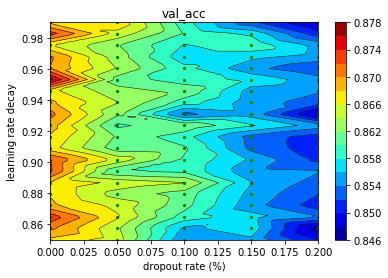

In [0]:
plot_contour(np.asarray(results['dropout']),
             np.asarray(results['decay']),
             np.asarray(results['val_acc'])[:,-1],
             'dropout rate (%)',
             'learning rate decay',
             'val_acc')

In [0]:
index = np.argmax(np.asarray(results['val_acc'])[:,-1])
print(np.asarray(results['dropout'])[index])
print(np.asarray(results['decay'])[index])
print(np.asarray(results['val_acc'])[index,-1])

0.0
0.9531578947368421
0.8766


In [0]:
dropouts = [i/10 for i in range(10)]
keys = ['dropout', 'val_acc', 'val_loss']
results = {}
for key in keys:
    results[key] = []
for dropout in dropouts:
    print('dropout rate = {}'.format(dropout))
    clf = NN(Losses.softmax_cross_entropy, Optimizers.RMSProp, regularizer=Regularizers.l1, reg_lambda=10**(-4.96))
    clf.add(Layers.Dense(128, input_dim=n))
    clf.add(Layers.Dense(96, activation='lrelu', batch_norm=(0.99, 0.001, 1e-5), dropout_rate=dropout))
    clf.add(Layers.Dense(64, activation='lrelu', batch_norm=(0.99, 0.001, 1e-5), dropout_rate=dropout))
    clf.add(Layers.Dense(10, activation='softmax'))
    epochs = 5
    result = clf.fit(x_train,
                   y_train,
                   learning_rate=10**(-2.465),
                   batch_size=128,
                   epochs=epochs,
                   print_freq=1,
                   gamma=0.0,
                   decay=0.9531578947368421,
                   validation=(x_val, y_val))
    loss, acc, val_loss, val_acc = result['Loss'], result['Accuracy'], result['Val Loss'], result['Val Accuracy']
    results['dropout'].append(dropout)
    results['val_acc'].append(val_acc)
    results['val_loss'].append(val_loss)

dropout rate = 0.0
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 1/5 training loss = 1.88273, training accuracy = 74.41600%   validation loss = 0.79406, validation accuracy = 74.71%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 2/5 training loss = 0.70206, training accuracy = 80.362%   validation loss = 0.57285, validation accuracy = 80.38%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 3/5 training loss = 0.55562, training accuracy = 83.09%   validation loss = 0.49821, validation accuracy = 82.55%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 4/5 training loss = 0.48624, training accuracy = 84.462%   validation loss = 0.45936, validation accuracy = 83.69%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 5/5 training loss = 0.44123, training accuracy = 85.736%   validation loss = 0.43559, validation accuracy = 84.45

In [0]:
index = np.argmax(np.asarray(results['val_acc'])[:,-1])
print(np.asarray(results['dropout'])[index])
print(np.asarray(results['val_acc'])[index,-1])

0.0
0.8445


## 8- Number of epochs
<p>
    We ran our model with all the optimized hyper parameters using <b>1500 epochs</b> to find optimal number of epochs.<br>
    The validation loss seem to have lowest value at <b>86 epochs</b> and after that the model seem to overfit. Therefore we use that number in our final model.<br>
    Here is a summary of our final model:<br>
    <li>Network architecture</li>
<table>
    <tr>
        <th>layer</th>
        <th>number<br>of neurons</th>
        <th>activation</th>
        <th>batch<br>normaliztion</th>     
    </tr>
    <tr>
        <td>input<br>layer</td>
        <td>128</td>
        <td> - </td>
        <td> - </td>
    </tr>
    <tr>
        <td>hidden<br>layer 1</td>
        <td>96</td>
        <td>lrelu</td>
        <td>$(\gamma = 0.99, \beta = 0.001, \epsilon = 1e^{-5})$</td>
    </tr>
    <tr>
        <td>hidden<br>layer 2</td>
        <td>64</td>
        <td>lrelu</td>
        <td>$(\gamma = 0.99, \beta = 0.001, \epsilon = 1e^{-5})$</td>
    </tr>
    <tr>
        <td>output<br>layer</td>
        <td>10</td>
        <td>softmax</td>
        <td> - </td>
    </tr>
</table>
    <li>Model parameters</li>
<table>
    <tr>
        <th>technique</th>
        <th>hyper<br>parameter</th>
        <th>value</th>
    </tr>
    <tr>
        <td>loss</td>
        <td>softmax<br>cross entropy</td>
        <td>-</td>
    </tr>
    <tr>
        <td>optimizer</td>
        <td>RMSProp</td>
        <td> - </td>
    </tr>
    <tr>
        <td>L1<br>regularization</td>
        <td>$\lambda$</td>
        <td>$10^{-4.96}$</td>
    </tr>
    <tr>
        <td>learning<br>rate</td>
        <td>$\alpha$</td>
        <td>$10^{-2.465}$</td>
    </tr>
    <tr>
        <td>learning<br>rate decay</td>
        <td>$\beta$</td>
        <td>0.95316</td>
    </tr>
    <tr>
        <td>number of<br>iterations</td>
        <td>epochs</td>
        <td>86</td>
    </tr>
    <tr>
        <td>output layer<br>activation</td>
        <td>softmax</td>
        <td> - </td>
    </tr>
</table>
</p>

 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 1/1500 training loss = 2.13731, training accuracy = 74.028%   validation loss = 0.81491, validation accuracy = 73.8%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 2/1500 training loss = 0.70411, training accuracy = 79.834%   validation loss = 0.57803, validation accuracy = 79.34%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 3/1500 training loss = 0.55461, training accuracy = 82.54%   validation loss = 0.49673, validation accuracy = 82.39%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 4/1500 training loss = 0.48759, training accuracy = 84.538%   validation loss = 0.44632, validation accuracy = 83.77%   
 [████████████████████████████████████████████████████████████] 100.0%  
Epoch 5/1500 training loss = 0.45022, training accuracy = 85.014%   validation loss = 0.42122, validation accuracy = 84.5%   
 [█

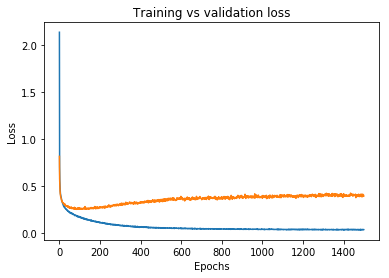

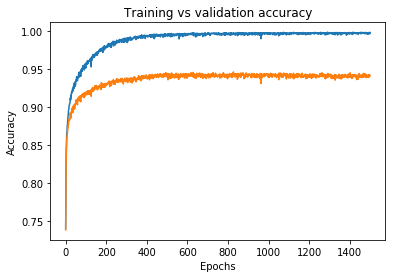

0.9464


In [0]:
epochs = 1500
clf = NN(Losses.softmax_cross_entropy,
         Optimizers.RMSProp,
         regularizer=Regularizers.l1,
         reg_lambda=10**(-4.96))
clf.add(Layers.Dense(128, input_dim=n, dropout_rate=0.00))
clf.add(Layers.Dense(96, activation='lrelu', batch_norm=(0.99, 0.001, 1e-5)))
clf.add(Layers.Dense(64, activation='lrelu', batch_norm=(0.99, 0.001, 1e-5)))
clf.add(Layers.Dense(10, activation='softmax'))

result = clf.fit(x_train,
                 y_train,
                 learning_rate=10**(-2.465),
                 batch_size=128,
                 epochs=epochs,
                 print_freq=1,
                 gamma=0.0,
                 decay=0.9531578947368421,
                 validation=(x_val, y_val))

loss, acc, val_loss, val_acc = result['Loss'], result['Accuracy'], result['Val Loss'], result['Val Accuracy']
clf = result['Best model']

epoch = [i for i in range(len(loss))]
plt.plot(epoch, loss)
plt.plot(epoch, val_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs validation loss')
plt.show()


plt.plot(epoch, acc)
plt.plot(epoch, val_acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs validation accuracy')
plt.show()

print(max(val_acc))


## 9- k-fold validation
using k = 6, we got <b>k-fold validation accuracy of 91.37%</b>

In [3]:
def create_folds(data, label, k):
    x_folds = []
    y_folds = []
    indices = np.array(range(data.shape[0]))
    indices = np.random.choice(indices, size=indices.shape)
    fold_size = data.shape[0] // k
    for i in range(k-1):
        x_folds.append(data[indices[i * fold_size : (i+1) * fold_size]])
        y_folds.append(label[indices[i * fold_size : (i+1) * fold_size]])
        x_folds.append(data[indices[(k - 1) * fold_size :]])
        y_folds.append(label[indices[(k - 1) * fold_size :]])
    return x_folds, y_folds

def center_norm(x_train, x_val):
    std_x = np.std(x_train)
    mean_x = np.mean(x_train)

    x_train = (x_train - mean_x) / std_x
    x_val = (x_val - mean_x) / std_x
    return x_train, x_val

k=6
epochs = 86
x_folds, y_folds = create_folds(data, label, k)
results = []

for i in range(k):
    print('Fold {} / {}'.format(i+1, k))
    x_val = x_folds[i]
    y_val = y_folds[i]
    x_train = np.concatenate(x_folds[:i] + x_folds[(i + 1):])
    y_train = np.concatenate(y_folds[:i] + y_folds[(i + 1):])
    x_train, x_val = center_norm(x_train, x_val)

    clf = NN(Losses.softmax_cross_entropy,
           Optimizers.RMSProp,
           regularizer=Regularizers.l1,
           reg_lambda=10**(-4.96))
    clf.add(Layers.Dense(128, input_dim=x_train.shape[0]))
    clf.add(Layers.Dense(96, activation='lrelu', batch_norm=(0.99, 0.001, 1e-5)))
    clf.add(Layers.Dense(64, activation='lrelu', batch_norm=(0.99, 0.001, 1e-5)))
    clf.add(Layers.Dense(10, activation='softmax'))

    result = clf.fit(x_train,
                   y_train,
                   learning_rate=10**(-2.465),
                   batch_size=128,
                   epochs=epochs,
                   print_freq=epochs,
                   gamma=0.0,
                   decay=0.9531578947368421)
    y_pred = clf.predict(x_val)
    results.append(Metrics.accuracy(y_val, y_pred))
    print('Validation accuracy = {}'.format(results[-1]))
    print()

Fold 1 / 6
 [████████████████████████████████████████████████████████████] 100.0%  

Validation accuracy = 0.9084

Fold 2 / 6
 [████████████████████████████████████████████████████████████] 100.0%  

Validation accuracy = 0.9156

Fold 3 / 6
 [████████████████████████████████████████████████████████████] 100.0%  

Validation accuracy = 0.9161

Fold 4 / 6
 [████████████████████████████████████████████████████████████] 100.0%  

Validation accuracy = 0.916

Fold 5 / 6
 [████████████████████████████████████████████████████████████] 100.0%  

Validation accuracy = 0.9106

Fold 6 / 6
 [████████████████████████████████████████████████████████████] 100.0%  

Validation accuracy = 0.9157



In [5]:
print('K-Fold validation accuracy = {}'.format(sum(results)/len(results)))

K-Fold validation accuracy = 0.9137333333333334


## 10- Ensemble of 10 neural networks
The final experiment is to train 10 models with random initalization and average their perdications<br>
<b>The validation accuracy for this experiment is 93.53%</b>

In [6]:
x_train, y_train, x_val, y_val = split_dataset(data, label, n)
y_pred = 0
epochs = 86
n_models = 10
for i in range(n_models):
    clf = NN(Losses.softmax_cross_entropy,
           Optimizers.RMSProp,
           regularizer=Regularizers.l1,
           reg_lambda=10**(-4.96))
    clf.add(Layers.Dense(128, input_dim=x_train.shape[0]))
    clf.add(Layers.Dense(96, activation='lrelu', batch_norm=(0.99, 0.001, 1e-5)))
    clf.add(Layers.Dense(64, activation='lrelu', batch_norm=(0.99, 0.001, 1e-5)))
    clf.add(Layers.Dense(10, activation='softmax'))

    result = clf.fit(x_train,
                   y_train,
                   learning_rate=10**(-2.465),
                   batch_size=128,
                   epochs=epochs,
                   print_freq=epochs,
                   gamma=0.0,
                   decay=0.9531578947368421)
    y_pred += clf.predict(x_val) / n_models
    y_p = clf.predict(x_val)
    print('Validation accuracy = {}'.format(Metrics.accuracy(y_val, y_p)))
    print()  
    
print('Ensemble validation accuracy = {}'.format(Metrics.accuracy(y_val, y_pred)))
print()


 [████████████████████████████████████████████████████████████] 100.0%  

Validation accuracy = 0.9137

 [████████████████████████████████████████████████████████████] 100.0%  

Validation accuracy = 0.9133

 [████████████████████████████████████████████████████████████] 100.0%  

Validation accuracy = 0.9125

 [████████████████████████████████████████████████████████████] 100.0%  

Validation accuracy = 0.9155

 [████████████████████████████████████████████████████████████] 100.0%  

Validation accuracy = 0.9106

 [████████████████████████████████████████████████████████████] 100.0%  

Validation accuracy = 0.9179

 [████████████████████████████████████████████████████████████] 100.0%  

Validation accuracy = 0.911

 [████████████████████████████████████████████████████████████] 100.0%  

Validation accuracy = 0.909

 [████████████████████████████████████████████████████████████] 100.0%  

Validation accuracy = 0.9154

 [████████████████████████████████████████████████████████████] 10

## 11- training final model and saving results

In [7]:
path = './input/'

with h5py.File(path+'test_128.h5','r') as H:
    test_data = np.asarray(numpy.copy(H['data']))
    
indices = np.array(range(data.shape[0]))
indices = np.random.choice(indices, size=indices.shape)
x_train = data[indices]
y_train = label[indices]

std_x = np.std(x_train)
mean_x = np.mean(x_train)

x_train = (x_train - mean_x) / std_x
x_test = (test_data - mean_x) / std_x

In [8]:
y_pred = 0
epochs = 86
n_models = 10
for i in range(n_models):
    clf = NN(Losses.softmax_cross_entropy,
           Optimizers.RMSProp,
           regularizer=Regularizers.l1,
           reg_lambda=10**(-4.96))
    clf.add(Layers.Dense(128, input_dim=x_train.shape[0]))
    clf.add(Layers.Dense(96, activation='lrelu', batch_norm=(0.99, 0.001, 1e-5)))
    clf.add(Layers.Dense(64, activation='lrelu', batch_norm=(0.99, 0.001, 1e-5)))
    clf.add(Layers.Dense(10, activation='softmax'))

    result = clf.fit(x_train,
                   y_train,
                   learning_rate=10**(-2.465),
                   batch_size=128,
                   epochs=epochs,
                   print_freq=epochs,
                   gamma=0.0,
                   decay=0.9531578947368421)
    y_pred += clf.predict(x_test) / n_models

 [████████████████████████████████████████████████████████████] 100.0%  

 [████████████████████████████████████████████████████████████] 100.0%  

 [████████████████████████████████████████████████████████████] 100.0%  

 [████████████████████████████████████████████████████████████] 100.0%  

 [████████████████████████████████████████████████████████████] 100.0%  

 [████████████████████████████████████████████████████████████] 100.0%  

 [████████████████████████████████████████████████████████████] 100.0%  

 [████████████████████████████████████████████████████████████] 100.0%  

 [████████████████████████████████████████████████████████████] 100.0%  

 [████████████████████████████████████████████████████████████] 100.0%  



In [9]:
test_size = test_data.shape[0]
y_pred = np.argmax(y_pred, axis=1)

In [10]:
print(y_pred[:20])

[9 2 1 1 6 1 4 6 5 7 4 5 5 3 4 1 2 2 8 0]


In [0]:
outpath = './output/'
with h5py.File(outpath+'Predicted_labels.h5','w') as H:
    H.create_dataset('label', (test_size,), data=np.asnumpy(y_pred))

## 13 - Evaluating predicted results against test data
<p>To evaluate or <b><i>next level model</b></i>, we import test labels from keras and do simple accuracy calculation.</p>

In [7]:
import keras.datasets as datasets
(_,_),(_,test_labels) = datasets.fashion_mnist.load_data()

In [16]:
outpath = './output/'
y_pred = None
with h5py.File(outpath+'Predicted_labels.h5','r') as H:
    y_pred = np.asarray(numpy.copy(H['label']))

In [20]:
accuracy = sum(1 * (y_pred == test_labels)) / len(test_labels)
print('Final model accuracy is {}%'.format(accuracy * 100))

Final model accuracy is 89.96%
